In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import time
import datetime

In [175]:
training_data = pd.read_csv('csv_dataframes/features.csv',index_col = 'match_id')

In [176]:
training_data.head(10)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63
5,1430284186,1,11,5,1961,1461,19,0,1,6,...,4,4,0,-43.0,1453,0,512,2038,0,63
8,1430293701,1,8,3,967,1136,7,1,0,8,...,6,3,0,10.0,1968,0,1536,1983,12,63
9,1430299335,7,35,5,2117,1252,16,0,0,6,...,3,4,0,-15.0,4079,1,1540,0,63,0
11,1430308974,1,17,5,1527,906,10,0,1,7,...,3,4,0,26.0,3071,0,0,1572,0,63


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

# Подход 1: градиентный бустинг "в лоб"

1) Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [177]:
#axis=1 - columns, inplace - do operation in place, no need to "data = data.drop(...)"
training_data.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 
                    'barracks_status_dire',], axis=1, inplace=True)
#dont drop 'radiant_win' since it are response's

2) Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [178]:
count_series = training_data.count()

#shape of training data
shape = training_data.shape

#series with proportion of NaN's for different from zero columns
(shape[0] - training_data.count())[count_series != shape[0] ] / shape[0]

first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
first_blood_player2            0.452402
radiant_bottle_time            0.161380
radiant_courier_time           0.007117
radiant_flying_courier_time    0.282619
radiant_first_ward_time        0.018883
dire_bottle_time               0.166029
dire_courier_time              0.006953
dire_flying_courier_time       0.268415
dire_first_ward_time           0.018780
dtype: float64

$\bullet$ Событие "первая кровь" не успело произойти за первые 5 минут для 0.201100 части матчей - поэтому и пропуски в 'first_blood_time' , 'first_blood_team' , 'first_blood_player1'

$\bullet$ 'first_blood_player2' больше пропусков поскольку не всегда второй игрок причастен к "первой крови", ее можно совершить и в одиночку

3) Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [179]:
#inplace - do operation in place, no need to "data = data.drop(...)"
training_data.fillna(0,inplace = True)

4) Какой столбец содержит целевую переменную? Запишите его название.

In [180]:
X_train = training_data
Y_train = training_data['radiant_win']
X_train.drop(['radiant_win'],axis = 1,inplace = True)

5) Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [182]:
cross_val = KFold(n_splits = 5, shuffle=True)

scores = list()

for k in (10,20,30,40,50):
    start_time = datetime.datetime.now()

    #loss --- loss function to be optimized. ‘deviance’ refers to deviance 
    #(= logistic regression) for classification with probabilistic outputs. 
    #For loss ‘exponential’ gradient boosting recovers the AdaBoost algorithm.
    
    #learning_rate --- learning rate shrinks the contribution of each tree by learning_rate.
    #There is a trade-off between learning_rate and n_estimators.
    
    #max_depth --- maximum depth of the individual regression estimators. 
    #The maximum depth limits the number of nodes in the tree. 
    #Tune this parameter for best performance; the best value depends
    #on the interaction of the input variables.
    
    model = GradientBoostingClassifier(n_estimators=k, learning_rate=0.1, max_depth=3, loss='deviance')
    scores.append(cross_val_score(model, X_train, Y_train, cv=cross_val, scoring='roc_auc'))
    
    print ('n_estimators= ' + str(k) + '   Time: ' + str(datetime.datetime.now() - start_time))
    print ('scores: ' + str(scores[-1]) + '   mean score: ' + str(np.mean(scores[-1])),'\n')

n_estimators= 10   Time: 0:00:35.272584
scores: [0.66418204 0.67025109 0.66738257 0.66435517 0.66323569]   mean score: 0.6658813126053801 

n_estimators= 20   Time: 0:01:01.326870
scores: [0.68240163 0.68382205 0.68024823 0.68171616 0.68166956]   mean score: 0.681971528338126 

n_estimators= 30   Time: 0:01:35.470159
scores: [0.69060148 0.68861196 0.68460829 0.69388287 0.68928002]   mean score: 0.6893969231266078 

n_estimators= 40   Time: 0:02:08.214116
scores: [0.69474958 0.69073589 0.69632918 0.69486438 0.69539654]   mean score: 0.6944151156859403 

n_estimators= 50   Time: 0:02:52.543313
scores: [0.7014017  0.69700128 0.69271871 0.69423489 0.70014497]   mean score: 0.6971003098255883 



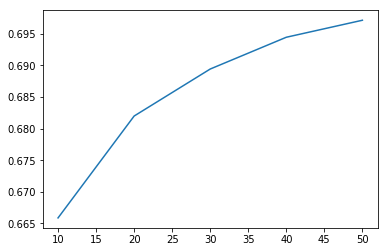

In [183]:
plt.plot([i for i in [10,20,30,40,50]],np.mean(scores,axis = 1))
plt.show()

In [ ]:
#another parametrs
"""
learning_rate=0.1, max_depth=3, loss='deviance' #default one's
#10 0.6650036791158828
#20 0.6816892391304116
#30 0.6892487017108454

learning_rate=0.1, max_depth=3, loss='exponential'
#10 0.6640383432748062
#20 0.6823159091238377
#30 0.6899110411186123

learning_rate=0.1, max_depth=5, loss='deviance'
#10 0.6795005997188351
#20 0.6919014871323015
#30 0.6989661751108933

learning_rate=0.3, max_depth=3, loss='deviance'
#10 0.6840534651256605
#20 0.696222071956785
#30 0.7011992731573018
"""

In [184]:
#best

k=100

cross_val = KFold(n_splits = 5, shuffle=True)
scores = list()

start_time = datetime.datetime.now()
model = GradientBoostingClassifier(n_estimators=k, learning_rate=0.3, max_depth=5, loss='exponential')
scores.append(cross_val_score(model, X_train, Y_train, cv=cross_val, scoring='roc_auc'))
    
print ('n_estimators= ' + str(k) + '   Time: ' + str(datetime.datetime.now() - start_time))
print ('scores: ' + str(scores[-1]) + '   mean score: ' + str(np.mean(scores[-1])),'\n')

n_estimators= 100   Time: 0:12:52.861502
scores: [0.71515807 0.70875846 0.71217856 0.71345207 0.70461807]   mean score: 0.7108330470836626 



# Подход 2: логистическая регрессия

Важно: не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

In [185]:
X_train = StandardScaler().fit_transform(X_train)

1) Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [187]:
cross_val = KFold(n_splits = 5, shuffle=True)

scores = list()

for c in [10 ** i for i in range(-3,6)]:
    start_time = datetime.datetime.now()
    
    #tol - Tolerance for stopping criteria.
    model = LogisticRegression(C = c, tol=1e-4)
    scores.append(cross_val_score(model, X_train, Y_train, cv=cross_val, scoring='roc_auc'))
    
    print ('C= ' + str(c) + '   Time: ' + str(datetime.datetime.now() - start_time))
    print ('scores: ' + str(scores[-1]) + '   mean score: ' + str(np.mean(scores[-1])),'\n')

C= 0.001   Time: 0:00:12.672070
scores: [0.7092448  0.7155247  0.72108682 0.71621884 0.71934961]   mean score: 0.7162849555126356 

C= 0.01   Time: 0:00:15.952121
scores: [0.7166394  0.71350158 0.71416978 0.7211218  0.71608093]   mean score: 0.7163026990021559 

C= 0.1   Time: 0:00:17.968950
scores: [0.71550982 0.7207094  0.71267179 0.71702808 0.71580376]   mean score: 0.7163445687790202 

C= 1   Time: 0:00:15.347061
scores: [0.71110518 0.71926261 0.71960398 0.71407571 0.71688426]   mean score: 0.7161863471590488 

C= 10   Time: 0:00:16.283268
scores: [0.72121151 0.71211243 0.71940759 0.71478795 0.714952  ]   mean score: 0.7164942964274748 

C= 100   Time: 0:00:17.603911
scores: [0.71572272 0.71902883 0.71391714 0.71484598 0.71881188]   mean score: 0.7164653097501008 

C= 1000   Time: 0:00:16.754403
scores: [0.7118205  0.71601598 0.71358171 0.72027304 0.71956599]   mean score: 0.7162514447663058 

C= 10000   Time: 0:00:15.945845
scores: [0.71679009 0.71399467 0.71437418 0.72282089 0.71

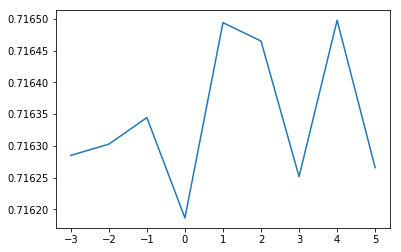

In [188]:
plt.plot([i for i in range(-3, 6)],np.mean(scores,axis = 1))
plt.show()

2) Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [189]:
training_data.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero',
           'd3_hero','d4_hero','d5_hero',],axis = 1, inplace = True)

X_train = StandardScaler().fit_transform(training_data)

In [190]:
cross_val = KFold(n_splits = 5, shuffle=True)

scores = list()

for c in [10 ** i for i in range(-3, 6)]:
    start_time = datetime.datetime.now()
    
    #tol - Tolerance for stopping criteria.
    model = LogisticRegression(C = c, tol=1e-4)
    scores.append(cross_val_score(model, X_train, Y_train, cv=cross_val, scoring='roc_auc'))
    
    print ('C= ' + str(c) + '   Time: ' + str(datetime.datetime.now() - start_time))
    print ('scores: ' + str(scores[-1]) + '   mean score: ' + str(np.mean(scores[-1])),'\n')

C= 0.001   Time: 0:00:10.144950
scores: [0.71899307 0.72245481 0.71029692 0.71302734 0.71726181]   mean score: 0.7164067909276663 

C= 0.01   Time: 0:00:12.626882
scores: [0.72335031 0.71829154 0.71574387 0.70972587 0.71561316]   mean score: 0.7165449509049279 

C= 0.1   Time: 0:00:13.038828
scores: [0.71987247 0.71799445 0.71115562 0.71606463 0.71728577]   mean score: 0.7164745885145789 

C= 1   Time: 0:00:13.328146
scores: [0.71797049 0.71692647 0.71603531 0.71386144 0.71742595]   mean score: 0.716443931262095 

C= 10   Time: 0:00:13.081935
scores: [0.71471492 0.71543844 0.71695968 0.72030061 0.71417641]   mean score: 0.7163180122146876 

C= 100   Time: 0:00:13.136307
scores: [0.72031929 0.71341785 0.72289276 0.71216562 0.71237334]   mean score: 0.716233772535525 

C= 1000   Time: 0:00:12.490557
scores: [0.71523912 0.71961866 0.71424909 0.71425524 0.71812952]   mean score: 0.7162983257127467 

C= 10000   Time: 0:00:13.201868
scores: [0.71702474 0.71862902 0.71294056 0.71752204 0.7154

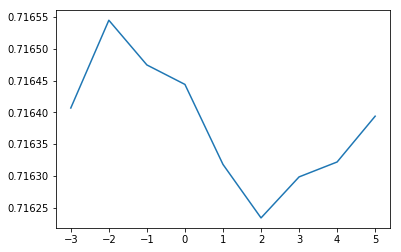

In [191]:
plt.plot([i for i in range(-3, 6)],np.mean(scores,axis = 1))
plt.show()

3) На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [192]:
#reload the data since we drop important columns
training_data = pd.read_csv('csv_dataframes/features.csv',index_col='match_id')
training_data.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire',
         'radiant_win'
        ], axis=1, inplace=True)

training_data.fillna(0,inplace = True)

In [193]:
#np.unique - all unique elements in data frame
unique_array = np.unique(training_data[['r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
                                         'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero']])

len(unique_array)

108

4) Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [194]:
X_pick = np.zeros((training_data.shape[0], 112))

#enumerate(list) = iterator like (1,list[0)),(2,list[1]),(3,list[2])
#.at - Access a single value
for i, match_id in enumerate(training_data.index):
    for p in range(1,6):
        X_pick[i, training_data.at[match_id, 'r{}_hero'.format(p)] -1] = 1
        X_pick[i, training_data.at[match_id, 'd{}_hero'.format(p)] -1] = -1
        
training_data.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
           'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero',],axis = 1, inplace = True)

X_train = np.hstack((training_data.values, X_pick))

X_train = StandardScaler().fit_transform(X_train)

5) Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [195]:
cross_val = KFold(n_splits = 5, shuffle=True)

scores = list()

for c in [10 ** i for i in range(-3, 6)]:
    start_time = datetime.datetime.now()
    
    #tol - Tolerance for stopping criteria.
    model = LogisticRegression(C = c, tol=1e-4)
    scores.append(cross_val_score(model, X_train, Y_train, cv=cross_val, scoring='roc_auc'))
    
    print ('C= ' + str(c) + '   Time: ' + str(datetime.datetime.now() - start_time))
    print ('scores: ' + str(scores[-1]) + '   mean score: ' + str(np.mean(scores[-1])),'\n')

C= 0.001   Time: 0:00:17.462968
scores: [0.75693496 0.74929428 0.75369613 0.75066884 0.74780501]   mean score: 0.751679841563776 

C= 0.01   Time: 0:00:23.360603
scores: [0.75443117 0.74985551 0.75120159 0.75040153 0.75305109]   mean score: 0.7517881780893723 

C= 0.1   Time: 0:00:24.643224
scores: [0.75436655 0.746435   0.75451021 0.75190504 0.75248388]   mean score: 0.7519401348636244 

C= 1   Time: 0:00:24.305757
scores: [0.75539631 0.756278   0.75033883 0.75141528 0.74609468]   mean score: 0.7519046192611075 

C= 10   Time: 0:00:25.122018
scores: [0.74514791 0.7520571  0.75835727 0.75683192 0.7472889 ]   mean score: 0.7519366218134864 

C= 100   Time: 0:00:25.711612
scores: [0.75310115 0.75124083 0.75137861 0.74913899 0.75492949]   mean score: 0.7519578129061995 

C= 1000   Time: 0:00:25.519726
scores: [0.75666098 0.75287958 0.74663868 0.75315606 0.75022858]   mean score: 0.7519127761696893 

C= 10000   Time: 0:00:26.423473
scores: [0.76182068 0.75499867 0.74244884 0.74999601 0.749

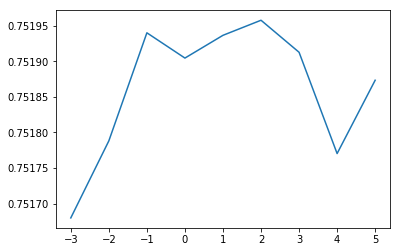

In [197]:
plt.plot([i for i in range(-3, 6)],np.mean(scores,axis = 1))
plt.show()

6) Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [198]:
##preparation for training_data

training_data = pd.read_csv('csv_dataframes/features.csv',index_col='match_id')
Y_train = training_data['radiant_win']
training_data.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant',
                    'barracks_status_dire','radiant_win'], axis=1, inplace=True)

training_data.fillna(0,inplace = True)

X_pick_train = np.zeros((training_data.shape[0], 112))

#enumerate(list) = iterator like (1,list[0)),(2,list[1]),(3,list[2])
#.at - Access a single value
for i, match_id in enumerate(training_data.index):
    for p in range(1,6):
        X_pick_train[i, training_data.at[match_id, 'r{}_hero'.format(p)] -1] = 1
        X_pick_train[i, training_data.at[match_id, 'd{}_hero'.format(p)] -1] = -1
        
training_data.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
           'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero',],axis = 1, inplace = True)

X_train = np.hstack((training_data.values, X_pick_train))

X_train = StandardScaler().fit_transform(X_train)

In [199]:
##preparation for test_data

test_data = pd.read_csv('csv_dataframes/features_test.csv',index_col = 'match_id')
test_data.fillna(0,inplace = True)

X_pick_test = np.zeros((test_data.shape[0], 112))

#enumerate(list) = iterator like (1,list[0)),(2,list[1]),(3,list[2])
#.at - Access a single value
for i, match_id in enumerate(test_data.index):
    for p in range(1,6):
        X_pick_test[i, test_data.at[match_id, 'r{}_hero'.format(p)] -1] = 1
        X_pick_test[i, test_data.at[match_id, 'd{}_hero'.format(p)] -1] = -1
        
test_data.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero',
           'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero',],axis = 1, inplace = True)

X_test = np.hstack((test_data.values, X_pick_test))

X_test = StandardScaler().fit_transform(X_train)

In [200]:
##fiting
model = LogisticRegression(C=100)
model.fit(X_train, Y_train)

result = model.predict_proba(X_test)

Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [201]:
result_for_radiant = [elem[1] for elem in result]
print('max: ' + str(max(result_for_radiant)))
print('min: ' + str(min(result_for_radiant)))

max: 0.9987353438671027
min: 0.0013200666813732913
